In [9]:
import numpy as np
import cv2
import pylab as plt
%matplotlib inline

In [2]:
img = cv2.imread('up.jpg',0)


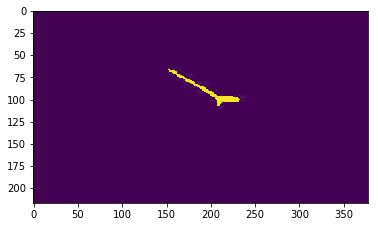

In [3]:
plt.imshow(img)

step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 2


'Display the results'

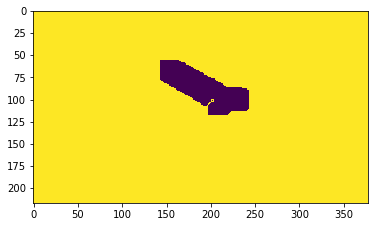

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
"load image data"
Img_Original =  cv2.imread( 'up.jpg',0)      # Gray image, rgb images need pre-conversion

"Convert gray images to binary images using Otsu's method"
from skimage.filters import threshold_otsu
Otsu_Threshold = threshold_otsu(Img_Original)   
BW_Original = Img_Original < Otsu_Threshold    # must set object region as 1, background region as 0 !


plt.imshow(BW_Original)

def neighbours(x,y,image):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    iter = 0
    while (changing1 or changing2) and iter<10:   #  iterates until no further changes occur in the image
        # Step 1
        iter += 1
        changing1 = []
        print "step 1"

        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0
        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned


"Apply the algorithm on images"
BW_Skeleton = zhangSuen(BW_Original)
plt.imshow(BW_Skeleton)
print "step 2"

# BW_Skeleton = BW_Original
"Display the results"
#fig, ax = plt.subplots(1, 2)
#ax1, ax2 = ax.ravel()
#ax1.imshow(BW_Original, cmap=plt.cm.gray)
#ax1.set_title('Original binary image')
#ax1.axis('off')
#ax2.imshow(BW_Skeleton, cmap=plt.cm.gray)
#ax2.set_title('Skeleton of the image')
#ax2.axis('off')
#plt.show()

In [ ]:
from scipy import weave
import numpy as np
import cv2
import sys

def _thinningIteration(im, iter):
	I, M = im, np.zeros(im.shape, np.uint8)
	expr = """
	for (int i = 1; i < NI[0]-1; i++) {
		for (int j = 1; j < NI[1]-1; j++) {
			int p2 = I2(i-1, j);
			int p3 = I2(i-1, j+1);
			int p4 = I2(i, j+1);
			int p5 = I2(i+1, j+1);
			int p6 = I2(i+1, j);
			int p7 = I2(i+1, j-1);
			int p8 = I2(i, j-1);
			int p9 = I2(i-1, j-1);

			int A  = (p2 == 0 && p3 == 1) + (p3 == 0 && p4 == 1) +
			         (p4 == 0 && p5 == 1) + (p5 == 0 && p6 == 1) +
			         (p6 == 0 && p7 == 1) + (p7 == 0 && p8 == 1) +
			         (p8 == 0 && p9 == 1) + (p9 == 0 && p2 == 1);
			int B  = p2 + p3 + p4 + p5 + p6 + p7 + p8 + p9;
			int m1 = iter == 0 ? (p2 * p4 * p6) : (p2 * p4 * p8);
			int m2 = iter == 0 ? (p4 * p6 * p8) : (p2 * p6 * p8);

			if (A == 1 && B >= 2 && B <= 6 && m1 == 0 && m2 == 0) {
				M2(i,j) = 1;
			}
		}
	} 
	"""

	weave.inline(expr, ["I", "iter", "M"])
	return (I & ~M)


def thinning(src):
	dst = src.copy() / 255
	prev = np.zeros(src.shape[:2], np.uint8)
	diff = None

	while True:
		dst = _thinningIteration(dst, 0)
		dst = _thinningIteration(dst, 1)
		diff = np.absolute(dst - prev)
		prev = dst.copy()
		if np.sum(diff) == 0:
			break

	return dst * 255

	src = cv2.imread("kanji.png")
	if src == None:
		sys.exit()
	bw = cv2.cvtColor(src, cv2.cv.CV_BGR2GRAY)
	_, bw2 = cv2.threshold(bw, 10, 255, cv2.THRESH_BINARY)
	bw2 = thinning(bw2)
	cv2.imshow("src", bw)
	cv2.imshow("thinning", bw2)
	cv2.waitKey()

